# STAT 344: Group Project

In [1]:
## Import statements
library(tidyverse)
library('GGally')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## Load Data

In [2]:
age_df <- read_csv('data/AgeDataset-V1.csv', na=c(""," ","NA"))  # changed to tidyverse format for faster loading
age_df <- age_df %>% rename_all(funs(make.names(.)))

Rows: 1223009 Columns: 10

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): Id, Name, Short description, Gender, Country, Occupation, Manner of...
dbl (3): Birth year, Death year, Age of death


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


In [3]:
# Quick look at what the data looks like
head(age_df)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q23,George Washington,1st president of the United States (1732–1799),Male,United States of America; Kingdom of Great Britain,Politician,1732,1799,natural causes,67
Q42,Douglas Adams,English writer and humorist,Male,United Kingdom,Artist,1952,2001,natural causes,49
Q91,Abraham Lincoln,16th president of the United States (1809-1865),Male,United States of America,Politician,1809,1865,homicide,56
Q254,Wolfgang Amadeus Mozart,Austrian composer of the Classical period,Male,Archduchy of Austria; Archbishopric of Salzburg,Artist,1756,1791,NA,35
Q255,Ludwig van Beethoven,German classical and romantic composer,Male,Holy Roman Empire; Austrian Empire,Artist,1770,1827,NA,57
Q260,Jean-François Champollion,French classical scholar,Male,Kingdom of France; First French Empire,Egyptologist,1790,1832,natural causes,42


## Data Clean-Up

In [4]:
set.seed(123)

We can use nrow() to get an idea of how large our population is. From the code below, we see that we have a population of around 1.2 million people.

In [5]:
pop_n <- nrow(age_df)
pop_n

[1] 1223009

### Skeleton draft bullet points (will be fleshed out after other sections have at least a skeleton draft too)
- We have 1.2 million observations, this is large enough s.t. we can treat this as a "population" for all notable deceased individuals.
- Our targeted population parameters is the mean age of death. This can be represented in two ways
    - Age of death as a numeric feature (no preprocessing needed)
    - Whether the individual died above the age of 72, or below the age of 72 (binary feature)
        - 72 is obtained through prior knowledge of the global mean age of death
- We choose strata based on subpopulations where the mean age of death may vary s.t. a data imbalance may skew the parameter
    - The dataset source states that there are only 107000 female entries in the population, and 124 non-binary entries.
    - Since the dataset spans multiple centuries, countries have changed names over time, stratifying this will be too complex
    - Occupation can be used as a strata as different jobs have different risks towards the individual, for example, a soldier may die younger than a politician.
        - However, there are over 9000 unique occupations in the dataset. As such, there are too many stratum to factor

In [6]:
age_df %>%  # find number of unique occupations
    select(Occupation) %>%
    n_distinct()

[1] 9314

To determine appropriate sample size, we first perform some basic computations.
- We want to be able to construct a C.I with a maximum width of 5 years
    - In the worst case, this allows us to approximately capture the number of decades a notable individual lives up to
- Using the standard nominal value of $\alpha = 0.05$, we construct accordingly.
- Under standard notation, let $\delta$ be half the width of the $(1-\alpha)$ C.I for $\hat{y}_P$. Then,

$$\delta = z_{a/2}\sqrt{(1-n/N)\dfrac{s^2_{guess}}{n}}$$



In order to use stratified sampling, we should get an idea of what sub-categories withing Gender our population contains.

In [7]:
gender_counts <- data.frame(table(age_df['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Var1,Freq
,<fct>,<int>
10,Male,981365
3,Female,107830
13,Transgender Female,79
17,Transgender Male,36
2,Eunuch; Male,18
5,Female; Male,7
6,Intersex,7
1,Eunuch,3
18,Transgender Male; Female,3


For stratified sampling, we need large enough groups. We can minimize the number of sub-categories by simplifying them to Male, Female, Transgender, and other. Where other encapsulates missing values, intersex, non-binary, and values that are not clear such as 'Female; Male'. While we know intersex and non-binary are not the same thing, we need groups large enough to be used in stratification.

In [8]:
# gender_dictionary <- c('Eunuch; Male'='Male','Female; Male'='Other','Transgender Male; Female'='Transgender Male',
#                           'Intersex; Female'='Intersex','Intersex; Male'='Intersex', 
#                           'Transgender Female; Male'='Transgender Female','Female; Female'='Female',
#                           'Transgender Female; Intersex'='Transgender Female',
#                           'Transgender Female; Female'='Transgender Female', 
#                           'Transgender Male; Male'='Transgender Male',
#                           'Intersex; Transgender Male'='Transgender Male',
#                           'Transgender Person; Intersex; Transgender Male'='Transgender Male',
#                           'Non-Binary; Intersex'='Other', 'Eunuch'='Male', 'Non-Binary'='Other')

In [9]:
gender_dictionary <- c('Eunuch; Male'='Male','Female; Male'='Other','Transgender Male; Female'='Transgender',
                          'Intersex; Female'='Other','Intersex; Male'='Other', 
                          'Transgender Female; Male'='Transgender','Female; Female'='Female',
                          'Transgender Female; Intersex'='Transgender',
                          'Transgender Female; Female'='Transgender', 
                          'Transgender Female'='Transgender',
                          'Transgender Male'='Transgender',
                          'Transgender Male; Male'='Transgender',
                          'Intersex'='Other',
                          'Intersex; Transgender Male'='Transgender',
                          'Transgender Person; Intersex; Transgender Male'='Transgender',
                          'Non-Binary; Intersex'='Other', 'Eunuch'='Male', 'Non-Binary'='Other')

In [10]:
age_df$Gender = age_df$Gender %>% replace_na('Other')

In [11]:
for (i in seq(1,length(gender_dictionary))){
    new_gender <- gender_dictionary[i]
    old_gender <- names(new_gender)
    age_df$Gender[age_df$Gender==old_gender]<-new_gender
    }

In [12]:
gender_counts <- data.frame(table(age_df['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Var1,Freq
,<fct>,<int>
2,Male,981386
3,Other,133667
1,Female,107831
4,Transgender,125


We will also re-lable "Male" and "Female" to "Cis-Male" and "Cis-Female" so as not to imply that Transgender Females are not Female, etc.

In [13]:
age_df$Gender[age_df$Gender == 'Male'] <- 'Cis-Male'

In [14]:
age_df$Gender[age_df$Gender == 'Female'] <- 'Cis-Female'

In [15]:
head(age_df, 3)
tail(age_df, 3)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q23,George Washington,1st president of the United States (1732–1799),Cis-Male,United States of America; Kingdom of Great Britain,Politician,1732,1799,natural causes,67
Q42,Douglas Adams,English writer and humorist,Cis-Male,United Kingdom,Artist,1952,2001,natural causes,49
Q91,Abraham Lincoln,16th president of the United States (1809-1865),Cis-Male,United States of America,Politician,1809,1865,homicide,56


Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q77249818,Diether Todenhagen,German navy officer and world war II U-boat commander,Other,Germany,Military personnel,1920,1944,NA,24
Q77253909,Reginald Oswald Pearson,"English artist, working in stained glass, printmaking and jewellery",Cis-Male,United Kingdom,Artist,1887,1915,NA,28
Q77254864,Horst Lerche,German painter,Cis-Male,Germany,Artist,1938,2017,NA,79


Since we have large $N$ for all genders except transgender, we only compute $n_0$ with the FPC for the transgender group. We approximate the FPC to $1$ for the other groups 

Solving for $n$,

$$n_0 = \dfrac{z_{\alpha / 2}^2s^2_{guess}}{\delta^2}$$

OR for stratified sampling

$$n_0 = \dfrac{\sigma}{\dfrac{\delta^2}{z_{\alpha/2}} + \dfrac{\sigma}{N}}$$

Currently, only have $\delta = 2.5$. Therefore, we need to compute $s^2_{guess}$. We use the dataset to approximate the population variance

In [16]:
values <- age_df %>% 
    group_by(Gender) %>%
    summarize(variance = var(Age.of.death, na.rm=TRUE),
              N = n())
values

Gender,variance,N
<chr>,<dbl>,<int>
Cis-Female,349.6675,107831
Cis-Male,262.4438,981386
Other,316.3084,133667
Transgender,390.1396,125


We can now find $n_0$ for each strata, and therefore the sum of each $n_0$ for the total minimum sample size (with stratification)

In [17]:
values <- values %>%
    mutate(n_0 = ceiling(variance / (2.5^2 / qnorm(0.975) + variance / N)))
values

Gender,variance,N,n_0
<chr>,<dbl>,<int>,<dbl>
Cis-Female,349.6675,107831,110
Cis-Male,262.4438,981386,83
Other,316.3084,133667,100
Transgender,390.1396,125,62


Now we find $\sum_{i=1}^{4} n_{0,i}$ where each $i$ is a different gender

In [18]:
sum(values$n_0)

[1] 355

Now we know the minimum sample size for a stratified sample is $355$ total samples. 

To confirm that this is an appropriate sample size for an SRS, we now compute $n_0$ without stratification. We omit the FPC since $N$ is sufficiently large.

In [19]:
age_df %>%
    summarize(variance = var(Age.of.death, na.rm=TRUE)) %>%
    mutate(n_0 = ceiling(qnorm(0.975)^2 * variance / (5/2)^2))

variance,n_0
<dbl>,<dbl>
276.5363,170


Since $n_{0} = 170$ for an SRS is smaller than $\sum_{i=1}^{4} n_{0,i} = 355$, we choose $\sum_{i=1}^{4} n_{0,i} = 355$ as our sample size

## Sample Data

### Simple Random Sample

First, we will take a simple random sample from our population. We set the seed to "123" for reproducibility.

In [20]:
set.seed(123)
age_srs <- age_df[sample(nrow(age_df), 500), ]
head(age_srs)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q1145126,Franz Joseph Adolph Heinrich Schulze Pellengahr,German farmer,Cis-Male,Germany,Farmer,1796,1829,NA,33
Q60818395,Giuseppe Frh. Menghin von Brezburg,"(1786 - 1860), Jurist",Cis-Male,NA,NA,1786,1860,NA,74
Q11439092,Ootani Shinsuke,politician,Other,NA,Politician,1844,1932,NA,88
Q5719213,Antti Eskola,"Finnish social psychologist, professor and non-fiction writer",Cis-Male,Finland,Researcher,1934,2018,NA,84
Q4719574,Alexander McArthur,British politician,Cis-Male,United Kingdom of Great Britain and Ireland,Politician,1814,1909,NA,95
Q6915881,Moses Mescheloff,American rabbi,Cis-Male,NA,Rabbi,1909,2008,NA,99


In [21]:
dim(age_srs)

[1] 500  10

In [22]:
gender_counts <- data.frame(table(age_srs['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Var1,Freq
,<fct>,<int>
2,Cis-Male,386
3,Other,67
1,Cis-Female,47


It seems that no Transgender data points were selected for our simple random sample.

### Stratified Sample

To take a disproportionate stratified sample, we will break our population up into it's gender sub-categories, and then retrieve a sample of the same size from each sub-category. This sample size is limited by the number of people in the Transgender category.

In [23]:
set.seed(123)
age_strat <- age_df %>%
  filter(Gender %in% c('Cis-Male','Cis-Female','Transgender','Other')) %>%
  group_by(Gender) %>%
  sample_n(125)

In [24]:
head(age_strat)

Id,Name,Short.description,Gender,Country,Occupation,Birth.year,Death.year,Manner.of.death,Age.of.death
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
Q7095215,Onésime Dorval,Missionary teacher,Cis-Female,Canada,Religious figure,1845,1932,NA,87
Q11713839,Irena Sułkowska-Kurasiowa,Polish historian,Cis-Female,Poland,Researcher,1917,2006,NA,89
Q130752,Elizabeth of Russia,Empress of Russia (1741-1762),Cis-Female,Russian Empire,Monarch,1709,1761,NA,52
Q3928578,Rachelina Ambrosini,Italian teenager who is venerated by the Roman Catholic Church,Cis-Female,Kingdom of Italy,Artist,1925,1941,natural causes,16
Q46994746,Nellie Carrington,British high jumper,Cis-Female,United Kingdom,High jumper,1916,1998,NA,82
Q59532926,Barbara Biber,"born:1903|died:1993|; Biber, Barbara; Biber, Barbara, b.1903; Biber, Barbara 1903-1993",Cis-Female,NA,NA,1903,1993,NA,90


In [25]:
gender_counts <- data.frame(table(age_strat['Gender']))
gender_counts[order(gender_counts$Freq, decreasing = TRUE), ]

,Var1,Freq
,<fct>,<int>
1,Cis-Female,125
2,Cis-Male,125
3,Other,125
4,Transgender,125


Here we have an equal amount of data points for each Gender sub-category in our population.

## Data Analysis

### Proportion with our Simple Random Sample

We want to examine the proportion of celebrities dying over the age of 72.6. The age of 72.6 was chosen because it is the world average life expectancy [source.](https://ourworldindata.org/life-expectancy) 

First, to visualize the sample, we plot a histogram distribution of the age of death.

In [26]:
options(repr.plot.width=10, repr.plot.height=7)

plot_prop_srs <- ggplot(age_srs, aes(x = Age.of.death)) + 
    geom_histogram(binwidth = 2, alpha = 0.5, position = "identity", colour = "black", fill = "lightgrey") + 
    geom_histogram(data=subset(age_srs,age_srs$Age.of.death>72.6),binwidth=2, 
    colour="black", fill="grey") + 
    xlab("Age of Death") + 
    ggtitle("Distribution of Age of Death for Celebrities") +
    theme(axis.title = element_text(size = 20)) +
    theme(plot.title = element_text(size = 24))

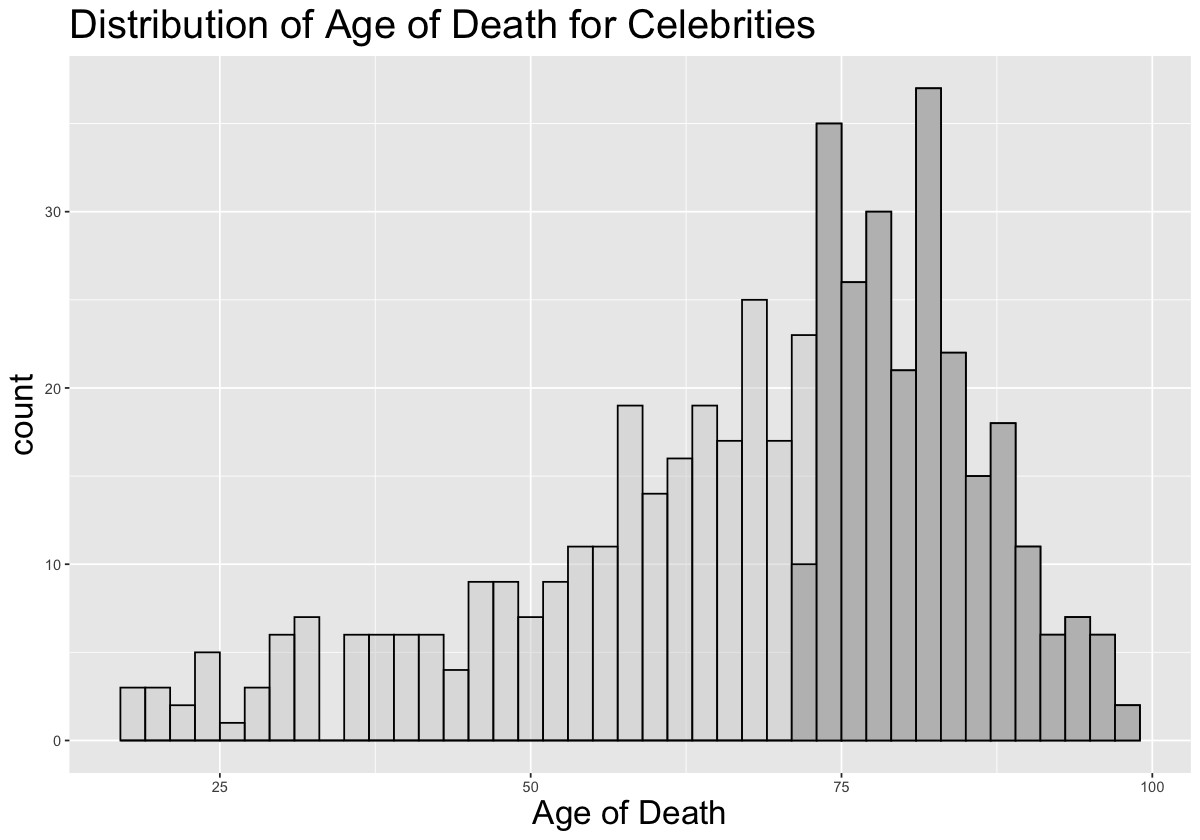

In [27]:
plot_prop_srs

Above is a histogram of the ages of death in our sample. The section of the histogram that is dark grey  contains the observations where age of death is over 72.6. Visually it looks like about 50% of the observations have age of death over 72.6.

Now, let's examine the proportion mathematically.

First we need to decide if we should use the finite population correction factor to make sure the Central Limit Theorem holds. In order to do this, we check if the ratio of sample size to population size is small enough.

In [28]:
nrow(age_srs)/pop_n

[1] 0.0004088277

0.0004 is sufficiently small that we do not need to use the population correction factor.

The formulas we need to use to calculate a proportion estimate and the confidence interval for proportion are the following:

$${\hat{p} = n_{d}/{n}}$$

$${\text{CI} = \hat{p}} \pm 1.96 \times {\sqrt{\frac{\hat{p} \times (1-\hat{p})}{n}}}$$


<br>


| Variable | Definition |
| - | :- | 
| $\hat{p}$ | the sample proportion of celebrities that died over the age of 72.6
| $n$ | the number of subjects in our sample
| $n_{d}$ | the number of subjects in our sample that died over the age of 72.6

In order for the above formulas to hold, we need to check that $np > 10$ and $n(p-1) > 10$. Based on our previous visualization, we can take 0.5 as an approximate proportion value.

In [29]:
nrow(age_srs)*0.5

[1] 250

250 is well above 10 so we can continue with using the proportion confidence interval formulas above.

In order to account for the worst case scenario for standard error, we will replace the $\hat{p}$ values in the standard error with the value 0.5.

In [30]:
proportion_estimate <- age_srs %>%
mutate(over = Age.of.death > 72.6) %>%
summarize(prop = mean(over),
          n = n(),
          se = sqrt(0.5*0.5/n),
         lower = prop - 1.96 * se,
         upper = prop + 1.96 * se)

In [31]:
proportion_estimate

prop,n,se,lower,upper
<dbl>,<int>,<dbl>,<dbl>,<dbl>
0.492,500,0.02236068,0.4481731,0.5358269


Our estimate for the proportion of celebrities that die over the age of 72.6, is 0.492. This is an unbiased estimate as $E[\hat{p}] = p$

Our standard error is around 2.2 percentage points. This indicates how much our sample proportion is likely to deviate from the population proportion.

Our confidence interval for proportion p has a lower bound of 0.458 and an upper bound of 0.536. We can interpret this as: if we take many samples of size n from the same celebrity population and construct a confidence interval for proportion based on each sample using the same formula, about 95% of all these confidence intervals will include the true value p.

As stated previously, the world average life expectancy is around 72.6. Our confidence interval for the proportion of celebrities that die over the age of 72.6 includes 0.5. This indicates that perhaps celebrity median life expectancy does not deviate too much from the 72.6 world life expectancy estimate.

In order to make our conclusions, we have been working under the assumption that the sample data drawn from the population of celebrities is unbiased, representative, independent and identically distributed. Using a simple random sample helps us be confident in this assumption. 

### Proportion with our Stratified Sample

Now, lets examine the proportion of celebrities dying over the age of 72.6 for our stratified sample.

Let's visualize with our stratified sample

In [32]:

plot_prop_strat <- ggplot(age_strat, aes(x = Age.of.death, fill = Gender)) + 
    geom_histogram(binwidth = 2, alpha = 0.4, position = "stack", colour = "black") + 
    geom_histogram(data=subset(age_strat,age_strat$Age.of.death>72.6),binwidth=2, 
    colour="black") + 
    geom_vline(aes(xintercept = 72.6), linewidth = 1) +
    xlab("Age of Death") + 
    ggtitle("Distribution of Age of Death for Celebrities") +
    theme(axis.title = element_text(size = 20)) +
    theme(plot.title = element_text(size = 24)) +
    theme(
        legend.title = element_text(size=20), #change legend title font size
        legend.text = element_text(size=15))

Warning message:
“Ignoring unknown parameters: linewidth”


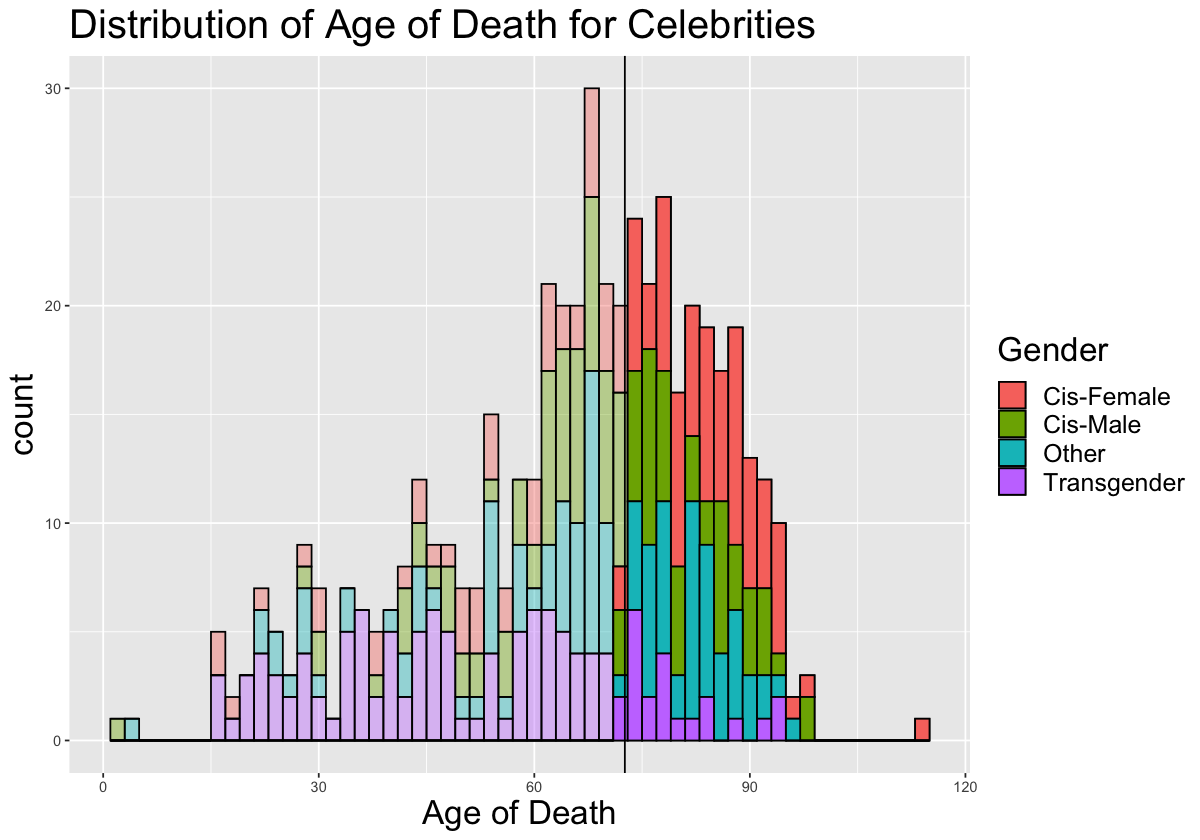

In [33]:
plot_prop_strat

Above is a histogram of the ages of death in our sample. The section of the histogram to the right of the black line contains the observations where age of death is over 72.6. This histogram is split by Gender, the variable we used for stratification. Visually it looks like most Transgender people in our sample died before the age of 72.6. Since our stratified sample contains a higher percentage of Transgender people, it's likely that the sample proportion of people who died over the age of 72.6 is lower than it was for our simple random sample.

Below is the formula for getting our proportion estimate, standard error, and confidence interval now that we have a stratified sample.


$$S_{p} = {\sum\limits_{h}{\frac{N_{h}}{N}} * p_{h}}$$

$$SE = {\sqrt{\sum\limits_{h}(1-{\frac{n_{h}}{N_{h}}})(\frac{N_{h}}{N})^2(\frac{S_{h}^2}{n_{h}})}}$$

$$CI = S_{p} \pm 1.96 \times SE$$

<br>


| Variable | Definition |
| - | :- | 
| $S_{p}$ | sample proportion estimate
| $p_{h}$ | sample proportion estimate in stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $N$ | total population size
| $N_{h}$ | number of units (in the population) that belong to stratum h
| $n_{h}$ | number of units sampled that belong to stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $SE$ | standard error for our proportion estimate
| $CI$ | confidence interval for our proportion estimate


.

Below we will carry out these calculations. For calculating the proportion and standard error for each strata group, we will use the same techniques that we used for the simple random sample.

In [34]:
## Strata proportion estimates

strat_proportion_estimate <- age_strat %>%
group_by(Gender) %>%
mutate(over = Age.of.death > 72.6) %>%
summarize(prop = mean(over),
          n = n(),
          se = sqrt(0.5*0.5/n))

strat_proportion_estimate

Gender,prop,n,se
<chr>,<dbl>,<int>,<dbl>
Cis-Female,0.624,125,0.04472136
Cis-Male,0.440,125,0.04472136
Other,0.440,125,0.04472136
Transgender,0.176,125,0.04472136


Since we are using the "worst case" value of 0.5 for calculating the standard error for each strata, and each strata has the same size, it makes sense that the standard error for proportion for each strata is the same. There is, however, a clear difference in the proportion estimates between each strata. The sample proportion of Transgender people dying over the age of 72.6 (0.176) seems to be much lower than the sample proportion of Cis-Females, Cis-Males, and Other dying over the age of 72.6 (0.624, 0.440, 0.440). This indicates that Transgender people may have a lower mean age of death compared to Cis-Males and Cis-Females.

In [35]:
## Sample proportion estimate

sample_proportion = 0

# Record total population size
N <- nrow(age_df)

# Record number of units that belong to each strata in the population
N_strata <- age_df %>%
group_by(Gender) %>%
summarize(strata_counts = n())

for (gender in c('Cis-Female', 'Cis-Male','Transgender', 'Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    p = strat_proportion_estimate %>%
 filter(Gender==gender)
    p = p[[2]]
    Nh = Nh[[2]]
    sample_proportion = sample_proportion + (Nh/N)*p
}

sample_proportion

[1] 0.456196

With our stratified sample we get a sample proportion estimate of 0.456. This is lower than our SRS estimate of 0.492. When calculating the standard error, we will need to use the population correction factor since the number of Transgender people in our sample is the same as the number of Transgender people in the population.

In [36]:
### Sample proportion standard error

sum_for_se = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender', 'Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    p_gen = strat_proportion_estimate %>%
 filter(Gender==gender)
    p = p_gen[[2]]
    nh = p_gen[[3]]
    se = p_gen[[4]]
    Nh = Nh[[2]]
    sum_for_se = sum_for_se + (1-nh/Nh)*(Nh/N)^2*(se^2/nh)
}

SE = sqrt(sum_for_se)
SE

[1] 0.003258268

Our standard error when we use the stratified sample estimate is a bit larger than the standard error for the SRS estimate. It's worth noting that the number of Transgender people in our sample is the same as the number of Transgender people in the population. Therefore when we use the finite population correction factor, our variance for the Transgender estimate becomes zero.

Now that we have an estimate and standard error, we can calculate a confidence interval.

In [37]:
upper_bound = sample_proportion + 1.96*SE
lower_bound = sample_proportion - 1.96*SE
upper_bound
lower_bound

[1] 0.4625822

[1] 0.4498098

We have a confidence interval of (0.45617,0.45622) for our stratified sample proportion estimate. We can interpret this as: if we take many stratified samples of size n from the same celebrity population and construct a confidence interval for proportion based on each sample using the same formula, about 95% of all these confidence intervals will include the true value p. Our confidence interval for proportion using the stratified sample also includes the value 0.5. Like with the simple random sample, this indicates that perhaps celebrity median life expectancy does not deviate much from the the 72.6 world life expectancy estimate.

For calculating this assumption, we are working under the assumption that each member of the population has been correctly classified into its Gender sub-group. This is not necessarily true as there were many missing values, and values with two Genders which got classified as "Other".

It was interesting to see the different in proportion estimates between the stratas. There are only 250 transgender data-points in our data-set of over a million values. So, a major benefit of using Stratified sampling is that we got to ensure estimates of reasonable precision for those in the Transgender category. 

### Mean with our Simple Random Sample

Now, lets investigate the mean age of death in our simple random sample. We can start with visualizaion of the vanilla mean estimator.

In [38]:
plot_both <- ggplot(age_srs, aes(x = Age.of.death)) + 
    geom_histogram(binwidth = 2, alpha = 0.5, position = "identity", aes(y = ..density..)) +
    xlab("Age of Death") + 
    geom_vline(aes(xintercept = mean(age_srs$Age.of.death))) +
    ggtitle("Distribution of Age of Death for Celebrities") +
    theme(axis.title = element_text(size = 15)) +
    theme(plot.title = element_text(size = 15))

Warning message:
“Use of `age_srs$Age.of.death` is discouraged. Use `Age.of.death` instead.”


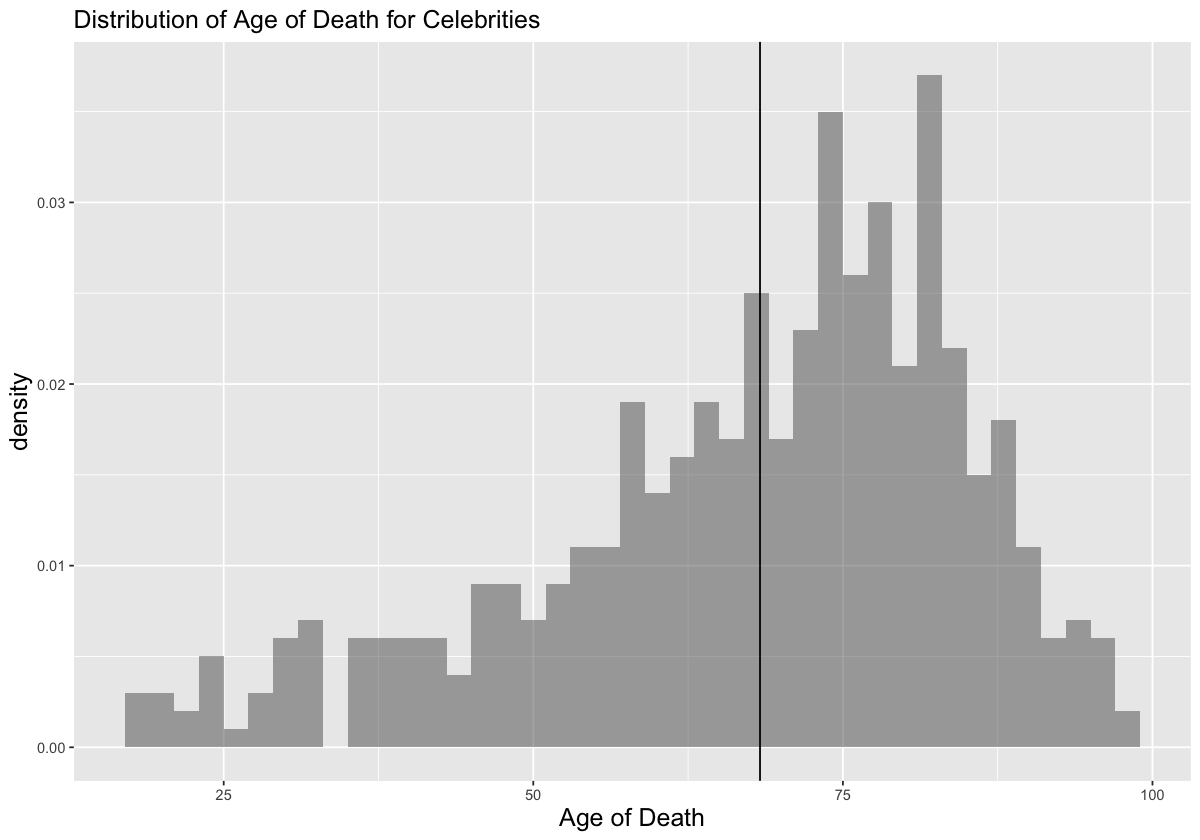

In [39]:
plot_both

It appears that the mean age of death in our simple random sample is around 70. Now, lets check the actual mean estimate, standard error, and confidence interval.

We have already determined that the finite population correction factor is not necessary for this simple random sample. Now, lets determine whether we should use a vanilla, ratio, or regression estimation for determining the mean. To do this, we will check to see if Age of Death is strongly correlated to any of the other numeric variables in our sample.

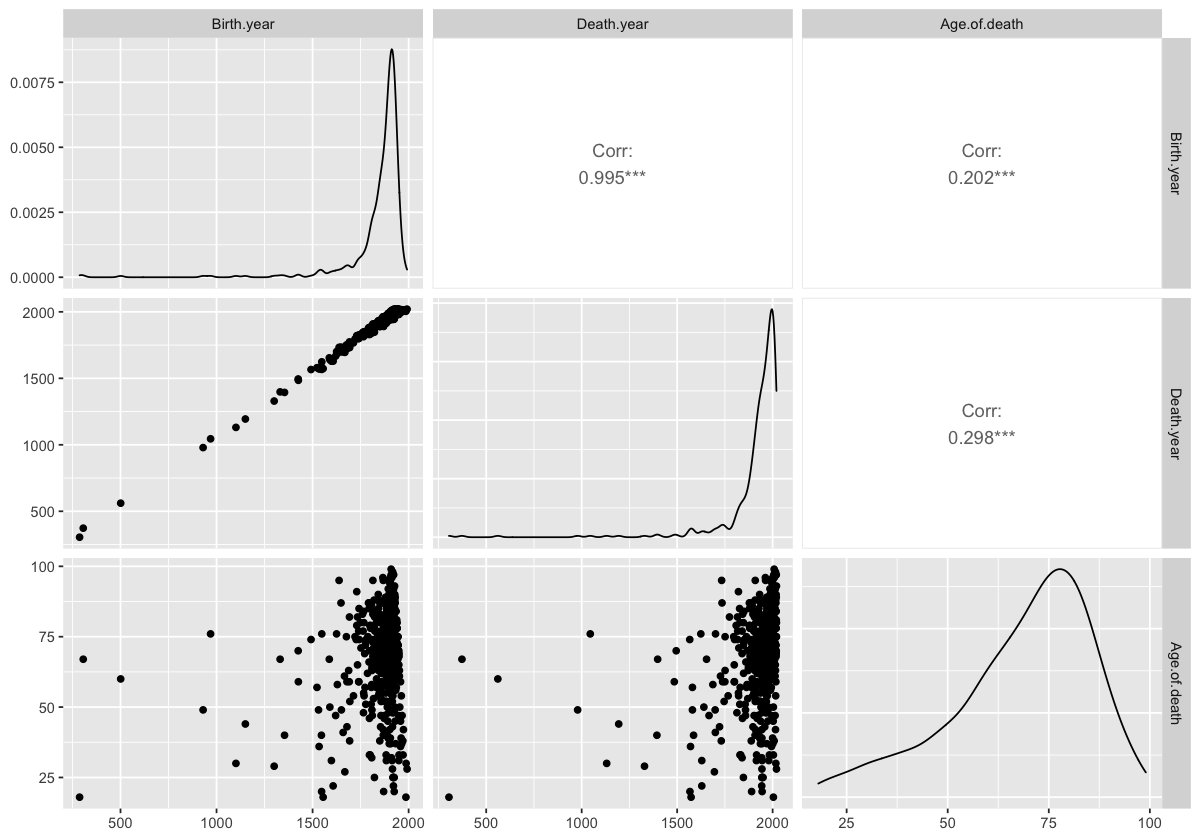

In [40]:
ggpairs(age_srs %>% select(c('Birth.year','Death.year','Age.of.death')))

There is not a strong correlation between Age of death and either of the numeric variables in our sample, therefore, we will use a vanilla estimate of the mean.

We can use the following formulas to check the mean estimate, standard error, and confidence interval.

$$\bar{y}_{s} = {\frac{{\sum{y_{i}}}}{n}}$$

$$e_{i} = y_{i} - \bar{y}_{s}$$

$$s_{e} ^ 2 = {\frac{1}{n-1}}*{\sum\limits_{i}{e_{i}^{2}}}$$

$${\text{CI} = \bar{y}_{s}} \pm 1.96 \times {\sqrt{\frac{s_{e} ^ 2}{n}}}$$


<br>


| Variable | Definition |
| - | :- | 
| $\bar{y}_{s}$ | the sample mean of Age of Death of celebrities
| $n$ | the number of subjects in our sample
| $y_{i}$ | the age of death of the ith celebrity in our sample

Below we will carry out these calculations.

In [41]:
ei_sum = sum((age_srs$Age.of.death - mean(age_srs$Age.of.death))^2)

means_estimate <- age_srs %>%
reframe(mean = mean(Age.of.death),
          n = n(),
          sample_error_var = 1/(n-1)*ei_sum,
          SE = sqrt(sample_error_var/n),
          lower = mean - 1.96 * SE,
          upper = mean + 1.96 * SE)
means_estimate

ERROR: Error in reframe(., mean = mean(Age.of.death), n = n(), sample_error_var = 1/(n - : could not find function "reframe"


We end up with a sample mean age of death of 68.308.

Our standard error for this estimate is 0.774.

Our confidence interval for this estimate is (67.79159,69.8244). Overall, this estimate seems to be fairly precise. From this confidence interval, which does not include the age 72.6, it seems there is some evidence that on average celebrities die at a younger age than the world like expectancy of 72.6.

We calculate these values under the assumption that our sample is large enough for the central Limit Theorem to hold. Since our sample is much larger than 30 we can be confident that this assumption holds. We also assume that the observations in our sample are equally likely to be obtained and independent. Since we used a simple random sample we can also be confident that this assumption holds.

### Mean with our Stratified Sample

In [ ]:
plot_mean_strat <- ggplot(age_strat, aes(x = Age.of.death, fill = Gender)) + 
    geom_histogram(binwidth = 2, alpha = 0.4, position = "stack", colour = "black") + 
    geom_vline(aes(xintercept = mean(age_strat$Age.of.death)), linewidth = 1.5) +
    xlab("Age of Death") + 
    ggtitle("Distribution of Age of Death for Celebrities") +
    theme(axis.title = element_text(size = 20)) +
    theme(plot.title = element_text(size = 24)) +
    theme(
        legend.title = element_text(size=20), #change legend title font size
        legend.text = element_text(size=15))

In [ ]:
plot_mean_strat

From this visualization, we can see that the vanilla mean age of death seems much lower than it was for our simple random sample.


$$\bar y_{str} = {\sum\limits_{h}{\frac{N_{h}}{N}} * \bar y_{Sh}}$$

$$SE\bar y_{str} = {\sqrt{\sum\limits_{h}(1-{\frac{n_{h}}{N_{h}}})(\frac{N_{h}}{N})^2(\frac{S_{h}^2}{n_{h}})}}$$

$$CI = \bar y_{str} \pm 1.96 \times SE\bar y_{str}$$

<br>


| Variable | Definition |
| - | :- | 
| $\bar y_{str}$ | sample mean estimate
| $\bar y_{Sh}$ | sample mean estimate in stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $N$ | total population size
| $N_{h}$ | number of units (in the population) that belong to stratum h
| $n_{h}$ | number of units sampled that belong to stratum h
| $S_{h}^2$ | sample variance for the sampled units that belong to stratum h
| $SE\bar y_{str}$ | standard error for our mean estimate
| $CI$ | confidence interval for our proportion estimate


In [ ]:
# Calculations

## Strata mean estimates

strat_mean_estimate <- age_strat %>%
group_by(Gender) %>%
mutate(ei2 = (Age.of.death - mean(age_srs$Age.of.death))^2) %>%
summarize(mean = mean(Age.of.death),
          n = n(),
          sample_error_var = 1/(n-1)*sum(ei2),
          SE = sqrt(sample_error_var/n),
          lower = mean - 1.96 * SE,
          upper = mean + 1.96 * SE)

strat_mean_estimate

Interestingly, the sample means vary by quite a lot within each strata. Those who are Transgender in our sample have a much lower mean age of death than those in the other gender sub-categories.

In [ ]:
## Sample mean estimate

sample_mean = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender','Other')) {
    Nh = N_strata %>%
filter(Gender == gender)
    m_gen = strat_mean_estimate %>%
 filter(Gender==gender)
    m = m_gen[[2]]
    Nh = Nh[[2]]
    sample_mean = sample_mean + (Nh/N)*m
}
sample_mean

Our estimate is actually fairly close to the estimate achieved with our simple random sample. This is because our calculations take into account the percentage of each strata in our population. This estimate may even be more accurate because we are including specific information regarding to the percentage of each gender in the population.

In [ ]:
### Sample mean standard error

sum_for_se = 0

for (gender in c('Cis-Female', 'Cis-Male','Transgender')) {
    Nh = N_strata %>%
filter(Gender == gender)
    m_gen = strat_mean_estimate %>%
 filter(Gender==gender)
    m = m_gen[[2]]
    nh = m_gen[[3]]
    se = m_gen[[5]]
    Nh = Nh[[2]]
    sum_for_se = sum_for_se + (1-nh/Nh)*(Nh/N)^2*(se^2/nh)
}

SE = sqrt(sum_for_se)
SE

Our standard error of about 0.1 is lower than the standard error we calculated for our simple random sample mean estimate (about 0.8). This indicates that our stratified sample estimate is more precise that our simple random sample estimate.

In [ ]:
upper_bound = sample_mean + 1.96*SE
lower_bound = sample_mean - 1.96*SE
lower_bound
upper_bound

Again our confidence interval does not include the age 72.6, it seems there is again some evidence that on average celebrities die at a younger age than the world like expectancy of 72.6.

A benefit of using a stratified sample is that we were able to notice interesting patterns within each strata, while making sure that the final mean estimate was representative of the population.

However, we have calculated these values under the assumption that each member of the population was properly sorted into the Gender sub-groups. This may not be the case as there were many missing values, and values with two Genders which got classified as "Other."